### Import Modules and Data

In [35]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import svm
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate, KFold, train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import RFE, RFECV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
from sklearn.neighbors import KNeighborsClassifier
from typing import Optional

In [36]:
df_ger = pd.read_csv("data/preprocessed_survey_results.csv")

#### Helper Functions

In [37]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

def ridge_plot(df_ridge_plot, x_label: str, y_label: str, row_order: Optional[list[str]]):
    # Initialize the FacetGrid object
    # pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
    g = sns.FacetGrid(df_ridge_plot, row=y_label, row_order=row_order, hue=y_label, aspect=15, height=.5)#, palette=pal, )

    # Draw the densities in a few steps
    g.map(sns.kdeplot, x_label, bw_adjust=.5, clip_on=False, fill=True, alpha=1, linewidth=1.5)
    g.map(sns.kdeplot, x_label, clip_on=False, color="w", lw=2, bw_adjust=.5)

    # passing color=None to refline() uses the hue mapping
    g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

    # Define and use a simple function to label the plot in axes coordinates
    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, .2, label, fontweight="bold", color=color,ha="left", va="center", transform=ax.transAxes)

    g.map(label, 'Salary')

    # Set the subplots to overlap
    g.figure.subplots_adjust(hspace=-.25)

    # Remove axes details that don't play well with overlap
    g.set_titles("")
    g.set(yticks=[], ylabel="")
    g.despine(bottom=True, left=True)

def calc_scores(estimators, x_test, y_test) -> (list, list, list, list, list):
    """
    Calculates the scores from multiple estimators. For example of cross validations.

    :param estimators: list of estimators
    :param x_test: x test split
    :param y_test: y test split
    :return: quadruple of list of the scores
    """
    r2_scores = []
    mae_scores =  []
    mape_scores = []
    rmse_scores = []
    max_scores = []
    for estimator in estimators:
        predictions = estimator.predict(x_test)
        r2_scores.append(metrics.r2_score(y_test, predictions))
        mae_scores.append(metrics.mean_absolute_error(y_test, predictions))
        mape_scores.append(metrics.mean_absolute_percentage_error(y_test, predictions))
        rmse_scores.append(np.sqrt(metrics.mean_squared_error(y_test, predictions)))
        max_scores.append(metrics.max_error(y_test, predictions))

    return r2_scores, mae_scores, mape_scores, rmse_scores, max_scores

## Correlation

,Salary,YearsCode,YearsCodePro
Salary,1.000000,0.350746,0.388739
YearsCode,0.350746,1.000000,0.871852
YearsCodePro,0.388739,0.871852,1.000000


<AxesSubplot:>

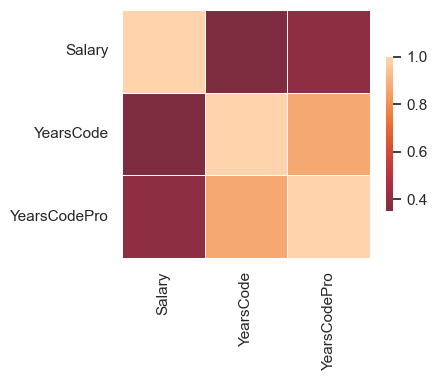

In [38]:
corr = df_ger[['Salary', 'YearsCode', 'YearsCodePro']].corr()
display(corr)
_, heatmap_ax = plt.subplots(figsize=(4, 4))
sns.heatmap(corr, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=heatmap_ax)

There is, as expected, a high correlation between the total years coded and years coded in the profession, so for the prediction of the salary we should only choose one. Additionally, it can be seen, that to the salary there is almost no correlation, so it seems like that the experience of coding in years has almost no effect on the salary.

In [39]:
corr = df_ger[['Salary', 'YearsCode', 'OrgSize', 'Age', 'in-person', 'remote']].corr()

display(corr)
_, heatmap_ax = plt.subplots(figsize=(4, 4))
sns.heatmap(corr, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=heatmap_ax)

KeyError: "['in-person', 'remote'] not in index"

## Plots

### Violinplots

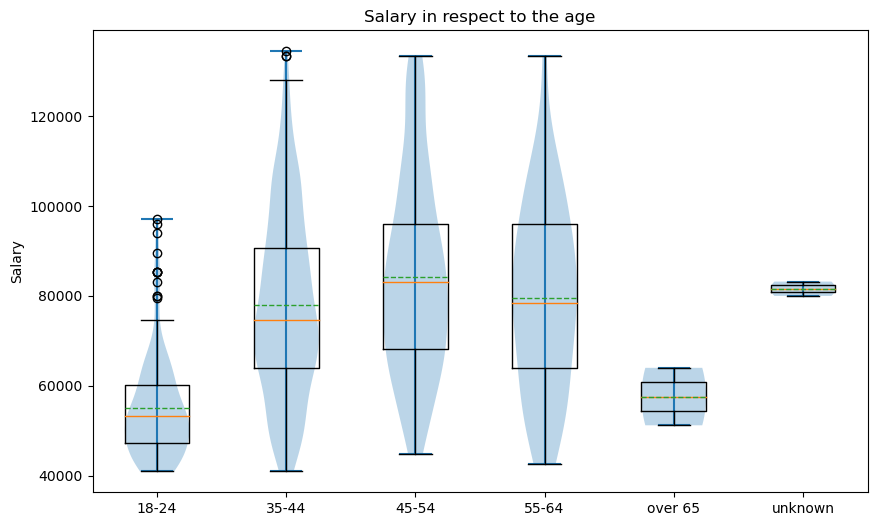

In [ ]:
data = [
    df_ger[df_ger['Age'] == "18-24"]['Salary'],
    df_ger[df_ger['Age'] == "35-44"]['Salary'],
    df_ger[df_ger['Age'] == "45-54"]['Salary'],
    df_ger[df_ger['Age'] == "55-64"]['Salary'],
    df_ger[df_ger['Age'] == "over 65"]['Salary'],
    df_ger[df_ger['Age'] == "unknown"]['Salary']
]
labels=["18-24", "35-44", "45-54", "55-64", "over 65", "unknown"]

_, ax = plt.subplots(figsize=(10, 6))
ax.violinplot(data)
ax.boxplot(data, showmeans=True, meanline=True)
ax.set_ylabel("Salary")
ax.set_xticklabels(labels)
ax.set(title='Salary in respect to the age')
plt.show()

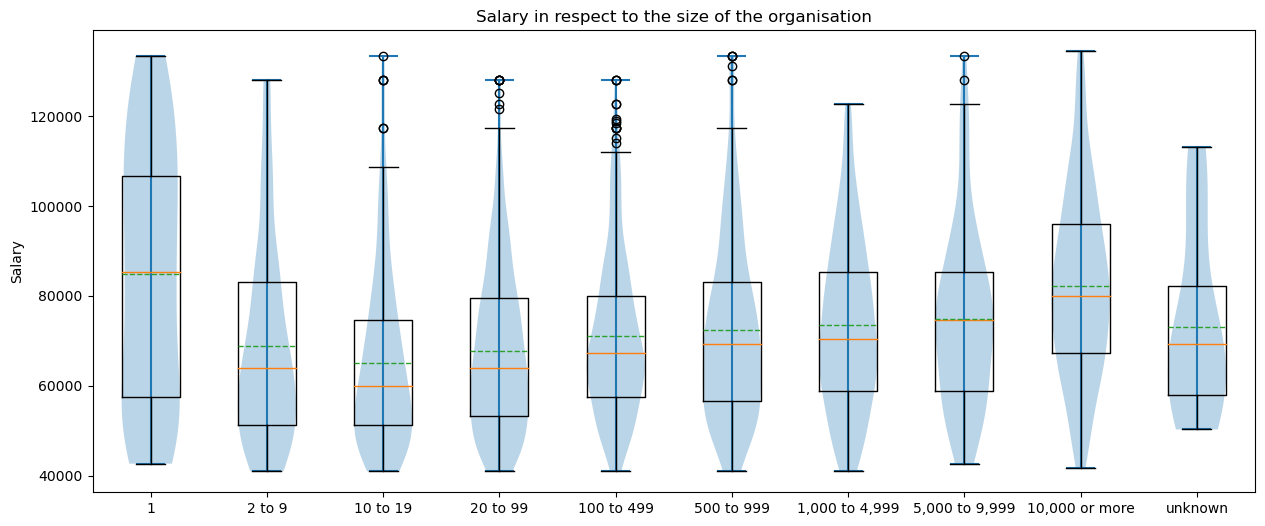

In [ ]:
data = [
    df_ger[df_ger['OrgSize'] == "1"]['Salary'],
    df_ger[df_ger['OrgSize'] == "2 to 9"]['Salary'],
    df_ger[df_ger['OrgSize'] == "10 to 19"]['Salary'],
    df_ger[df_ger['OrgSize'] == "20 to 99"]['Salary'],
    df_ger[df_ger['OrgSize'] == "100 to 499"]['Salary'],
    df_ger[df_ger['OrgSize'] == "500 to 999"]['Salary'],
    df_ger[df_ger['OrgSize'] == "1,000 to 4,999"]['Salary'],
    df_ger[df_ger['OrgSize'] == "5,000 to 9,999"]['Salary'],
    df_ger[df_ger['OrgSize'] == "10,000 or more"]['Salary'],
    df_ger[df_ger['OrgSize'] == "unknown"]['Salary']
]
labels=["1", "2 to 9", "10 to 19", "20 to 99", "100 to 499", "500 to 999", "1,000 to 4,999", "5,000 to 9,999", "10,000 or more", "unknown"]

_, ax = plt.subplots(figsize=(15, 6))
ax.violinplot(data)
ax.boxplot(data, showmeans=True, meanline=True)
ax.set_ylabel("Salary")
ax.set_xticklabels(labels)
ax.set(title='Salary in respect to the size of the organisation')
plt.show()

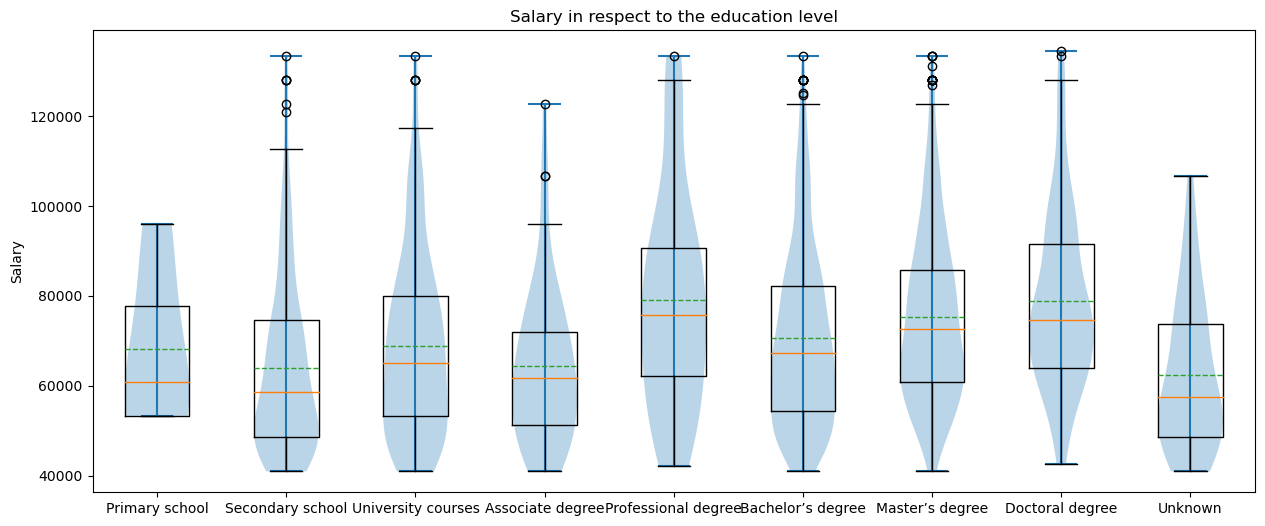

In [ ]:
data = [
    df_ger[df_ger['EdLevel'] == "Primary school"]['Salary'],
    df_ger[df_ger['EdLevel'] == "Secondary school"]['Salary'],
    df_ger[df_ger['EdLevel'] == "University courses"]['Salary'],
    df_ger[df_ger['EdLevel'] == "Associate degree"]['Salary'],
    df_ger[df_ger['EdLevel'] == "Professional degree"]['Salary'],
    df_ger[df_ger['EdLevel'] == "Bachelor’s degree"]['Salary'],
    df_ger[df_ger['EdLevel'] == "Master’s degree"]['Salary'],
    df_ger[df_ger['EdLevel'] == "Doctoral degree"]['Salary'],
    df_ger[df_ger['EdLevel'] == "Unknown"]['Salary']
]
labels=["Primary school","Secondary school","University courses","Associate degree","Professional degree","Bachelor’s degree","Master’s degree","Doctoral degree","Unknown"]

_, ax = plt.subplots(figsize=(15, 6))
ax.violinplot(data)
ax.boxplot(data, showmeans=True, meanline=True)
ax.set_ylabel("Salary")
ax.set_xticklabels(labels)
ax.set(title='Salary in respect to the education level')
plt.show()

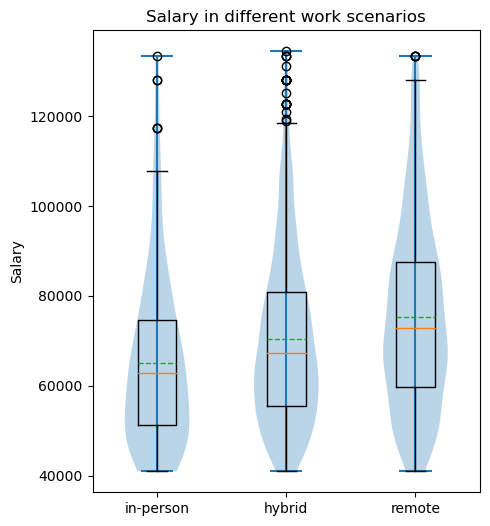

In [ ]:
data = [
    df_ger[df_ger['RemoteWork'] == "in-person"]['Salary'],
    df_ger[df_ger['RemoteWork'] == "hybrid"]['Salary'],
    df_ger[df_ger['RemoteWork'] == "remote"]['Salary']
]
labels=["in-person","hybrid","remote"]

_, ax = plt.subplots(figsize=(5, 6))
ax.violinplot(data)
ax.boxplot(data, showmeans=True, meanline=True)
ax.set_ylabel("Salary")
ax.set_xticklabels(labels)
ax.set(title='Salary in different work scenarios')
plt.show()

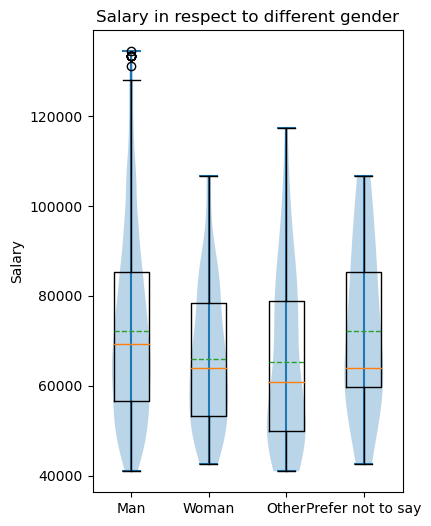

In [ ]:
data = [
    df_ger[df_ger['Gender'] == "Man"]['Salary'],
    df_ger[df_ger['Gender'] == "Woman"]['Salary'],
    df_ger[df_ger['Gender'] == "Other"]['Salary'],
    df_ger[df_ger['Gender'] == "Prefer not to say"]['Salary']
]
labels=["Man", "Woman", "Other", "Prefer not to say"]

_, ax = plt.subplots(figsize=(4, 6))
ax.violinplot(data)
ax.boxplot(data, showmeans=True, meanline=True)
ax.set_ylabel("Salary")
ax.set_xticklabels(labels)
ax.set(title='Salary in respect to different gender')
plt.show()

### Ridgeplots

In [ ]:
df_ridge = df_ger.copy()
df_ridge = df_ridge[df_ger['Salary']<300000]

ridge_plot(df_ridge[['Salary', 'Age']], y_label='Age', x_label='Salary', row_order=["unknown","under 18","18-24","25-34","35-44","45-54","55-64","over 65"])
ridge_plot(df_ridge[['Salary', 'OrgSize']], y_label='OrgSize', x_label='Salary', row_order=["unknown","1","2 to 9","10 to 19","20 to 99","100 to 499","500 to 999","1,000 to 4,999","5,000 to 9,999","10,000 or more"])
ridge_plot(df_ridge[['Salary', 'EdLevel']], y_label='EdLevel', x_label='Salary', row_order=["Unknown","Primary school","Secondary school","Professional degree","University courses","Associate degree","Bachelor’s degree","Master’s degree","Doctoral degree"])
ridge_plot(df_ridge[['Salary', 'RemoteWork']], y_label='RemoteWork', x_label='Salary', row_order=['in-person', 'hybrid', 'remote'])
ridge_plot(df_ridge[['Salary', 'Gender']], y_label='Gender', x_label='Salary', row_order=['Other', 'Prefer not to say', 'Man', 'Woman'])

NameError: name 'ridge_plot' is not defined

In [ ]:
ridge_plot(df_reg[['Salary', 'Age']], y_label='Age', x_label='Salary', row_order=None)
ridge_plot(df_reg[['Salary', 'OrgSize']], y_label='OrgSize', x_label='Salary', row_order=None)

### PairPlot

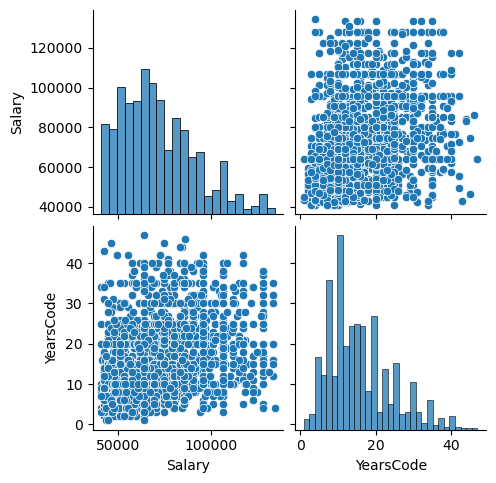

In [ ]:
rel = sns.pairplot(df_ger[['Salary', 'YearsCode', 'Age', 'OrgSize']])
rel.fig.subplots_adjust(top=.95)